In [2]:
import sys
import os
import pandas as pd
sys.path.append(os.path.abspath('../'))

from sklearn.model_selection import train_test_split
from scripts.imbalance_handler import ImbalanceHandler

Original shape: (120889, 196)
Resampled shape: (219136, 196)


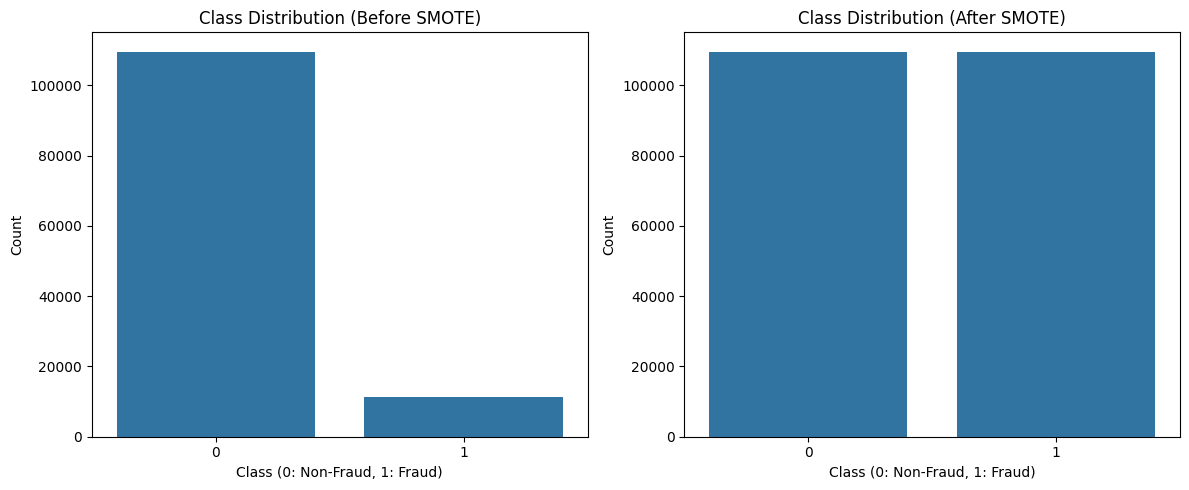

--- Before SMOTE ---
class
0    109568
1     11321
Name: count, dtype: int64
class
0    90.635211
1     9.364789
Name: proportion, dtype: float64

--- After SMOTE ---
class
0    109568
1    109568
Name: count, dtype: int64
class
0    50.0
1    50.0
Name: proportion, dtype: float64


In [4]:
# 1. import data
df = pd.read_csv("../data/processed/processed_data.csv")
X = df.drop('class', axis=1)
y = df['class']

# 2. Split into Train/Test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 3. Handle Imbalance on TRAINING data only
handler = ImbalanceHandler()
X_train_smote, y_train_smote = handler.resample_smote(X_train, y_train)

# 4. Visualize the results
handler.plot_comparison(y_train, y_train_smote)

# report

# 1. Before SMOTE 
print("--- Before SMOTE ---")
print(y_train.value_counts())
print(y_train.value_counts(normalize=True) * 100) # As percentages

# 2. After SMOTE
print("\n--- After SMOTE ---")
print(y_train_smote.value_counts())
print(y_train_smote.value_counts(normalize=True) * 100) # As percentages